<a href="https://colab.research.google.com/github/Pavansyamala/GenerativeAdverserialNN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot as plt

In [3]:
(train_x , train_y) , (test_x,test_y) = load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [11]:
train = train_x.copy()

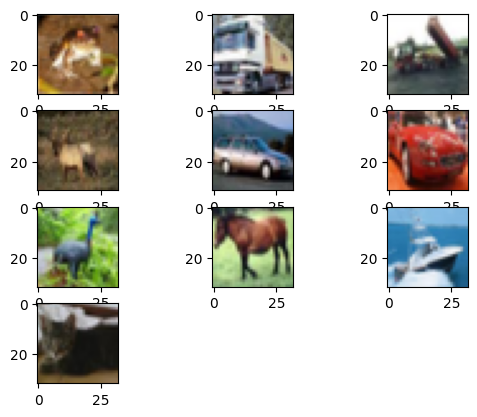

In [6]:
for i in range(10):
  plt.subplot(4,3,i+1)
  plt.imshow(train_x[i])
plt.show()

In [15]:
from keras.models import Sequential
from keras.layers import Dense , Conv2D , Flatten , Dropout , LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

In [16]:
import numpy as np

In [43]:
def define_descriminator(input_shape = (32,32,3)):

  model = Sequential()

  model.add(Conv2D(64 , (3,3) , padding = 'same' , input_shape = input_shape))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(128,(3,3),strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(128,(3,3),strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(256,(3,3),strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Flatten())

  model.add(Dropout(0.4))

  model.add(Dense(1,activation = 'sigmoid'))

  opt = Adam(lr = 0.002 , beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy' , optimizer = opt , metrics = ['accuracy'])
  return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 256)        

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


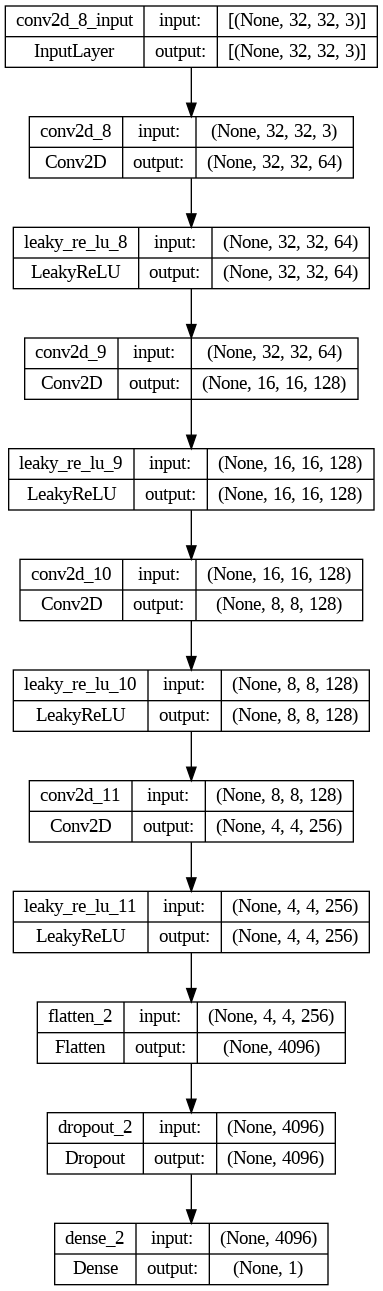

In [22]:
model = define_descriminator()
model.summary()
plot_model(model , to_file = 'discriminator_plot.png' , show_shapes = True , show_layer_names = True)

In [23]:
def load_real_sample():

  (train_x,_),(_,_) = load_data()
  x = train_x.astype('float32')

  x = (x-127.5)/127.5

  return x

In [29]:
def generate_real_samples(dataset,n_samples):
  ix = np.random.randint(0,dataset.shape[0] , n_samples)

  x = dataset[ix]

  y = np.ones((n_samples , 1))

  return x , y

In [30]:
dataset = load_real_sample()

x,y = generate_real_samples(dataset , 64)

In [36]:
def generate_fake_samples(n_samples):
  x = np.random.rand(32*32*3*n_samples)
  x = -1 + x*2
  x = x.reshape((n_samples , 32,32,3))
  y = np.zeros((n_samples,1))
  return x , y

In [37]:
fake_x , fake_y = generate_fake_samples(64)

In [46]:
def train_descriminator(model , dataset , n_iteration = 20 , n_batch = 128):

  half_batch = int(n_batch/2)

  for i in range(n_iteration):
    x_real , y_real = generate_real_samples(dataset , half_batch)

    _ , train_acc = model.train_on_batch(x_real , y_real)

    x_fake , y_fake = generate_fake_samples( half_batch)

    _ , train_acc_fake = model.train_on_batch(x_fake , y_fake)

    print(f'{i+1} iteration real accuracy {train_acc} and fake accuracy {train_acc_fake}')

In [48]:
model = define_descriminator()

dataset = load_real_sample()

train_descriminator(model , dataset)

1 iteration real accuracy 0.140625 and fake accuracy 0.0
2 iteration real accuracy 0.0 and fake accuracy 0.0
3 iteration real accuracy 0.859375 and fake accuracy 0.578125
4 iteration real accuracy 0.96875 and fake accuracy 0.984375
5 iteration real accuracy 0.984375 and fake accuracy 1.0
6 iteration real accuracy 0.890625 and fake accuracy 1.0
7 iteration real accuracy 0.984375 and fake accuracy 1.0
8 iteration real accuracy 1.0 and fake accuracy 1.0
9 iteration real accuracy 1.0 and fake accuracy 1.0
10 iteration real accuracy 1.0 and fake accuracy 1.0
11 iteration real accuracy 1.0 and fake accuracy 1.0
12 iteration real accuracy 1.0 and fake accuracy 1.0
13 iteration real accuracy 1.0 and fake accuracy 1.0
14 iteration real accuracy 1.0 and fake accuracy 1.0
15 iteration real accuracy 1.0 and fake accuracy 1.0
16 iteration real accuracy 1.0 and fake accuracy 1.0
17 iteration real accuracy 1.0 and fake accuracy 1.0
18 iteration real accuracy 1.0 and fake accuracy 1.0
19 iteration rea

In [49]:
from keras.models import Sequential
from keras.layers import Dense , Conv2D , Flatten , Dropout , LeakyReLU , Conv2DTranspose , Reshape
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

In [52]:
def define_generator(latent_dim):
  model = Sequential()
  # foundation_for 4*4 image
  n_nodes = 256*4*4

  model.add(Dense(n_nodes , input_dim = latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((4,4,256)))

  # Up sample to 8*8
  model.add(Conv2DTranspose(128 , (4,4) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Up sample to 16*16
  model.add(Conv2DTranspose(128 , (4,4) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Up Sample to 32 * 32
  model.add(Conv2DTranspose(128 , (4,4) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Output Layer

  model.add(Conv2D(3 , (3,3) , activation = 'tanh' , padding = 'same'))

  return model


In [54]:
gen_model = define_generator(100)

In [56]:
gen_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

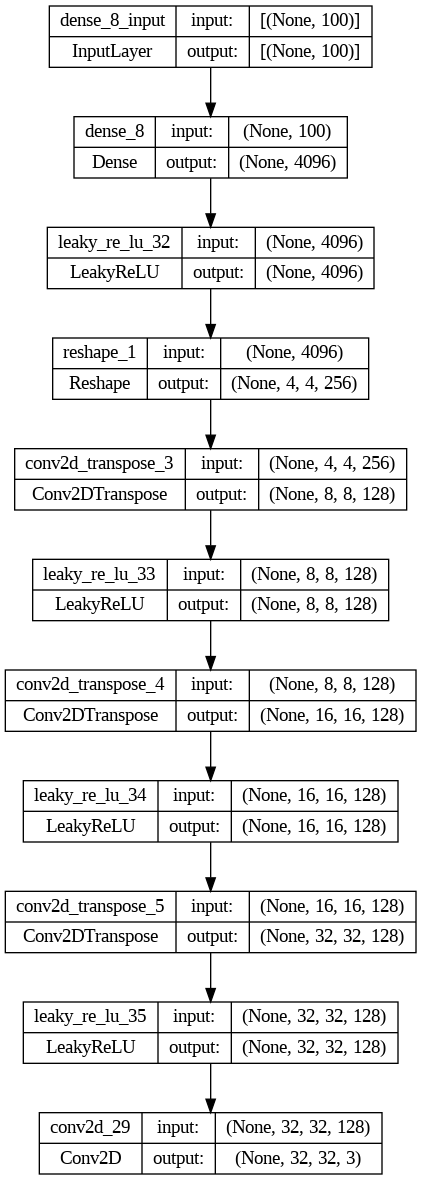

In [57]:
plot_model(gen_model , 'gen_model.png' , show_shapes = True , show_layer_names=True)